Imports

In [305]:
# imports ..
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns


Read the dataset

In [306]:
data_folder = './data/'
train_file = f'{data_folder}training_v2.csv'

target = 'hospital_death'

train_df = pd.read_csv(train_file)

train_df.head(5)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Explore the data

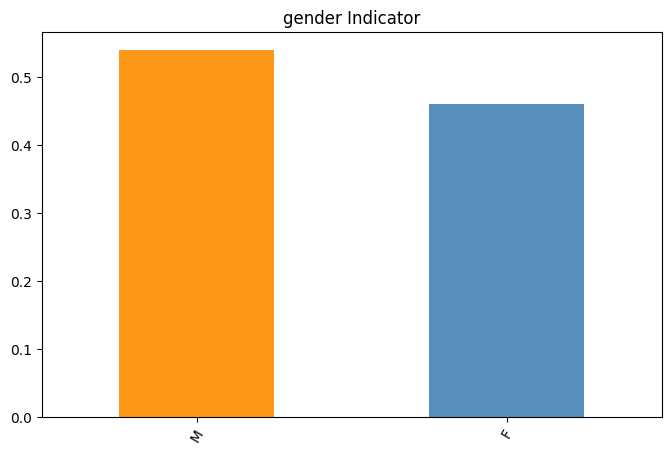

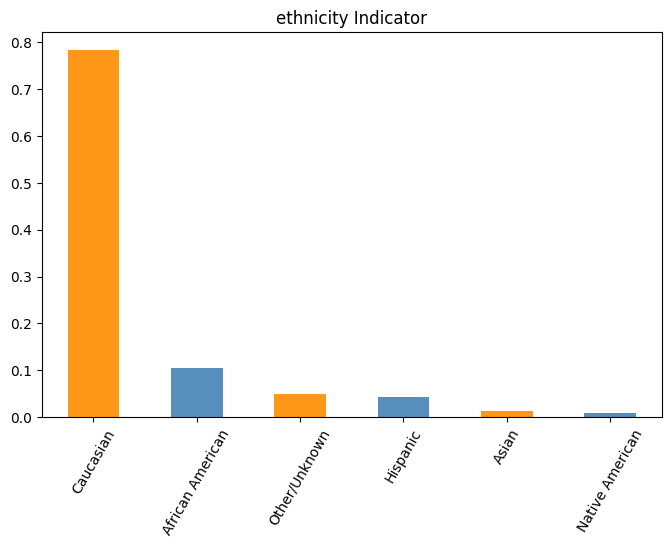

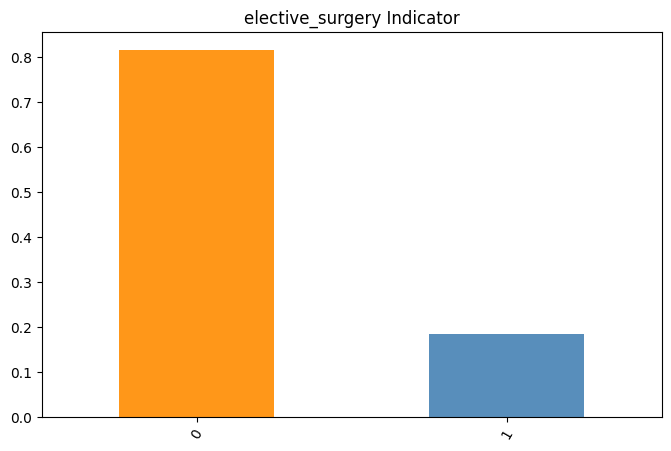

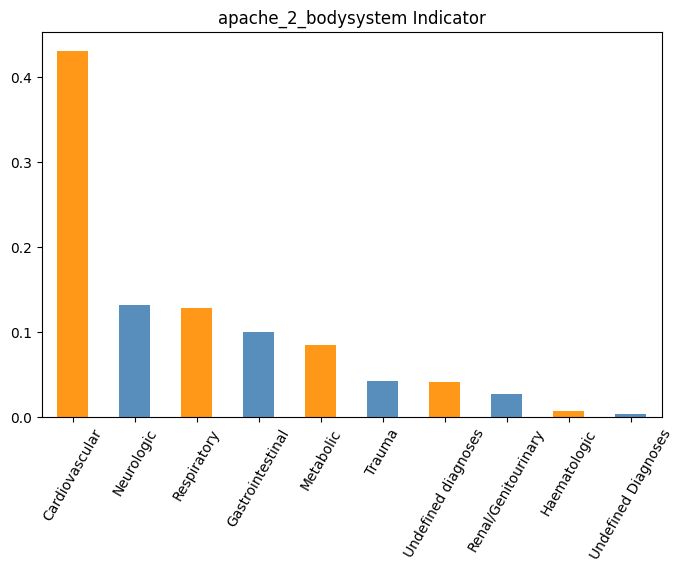

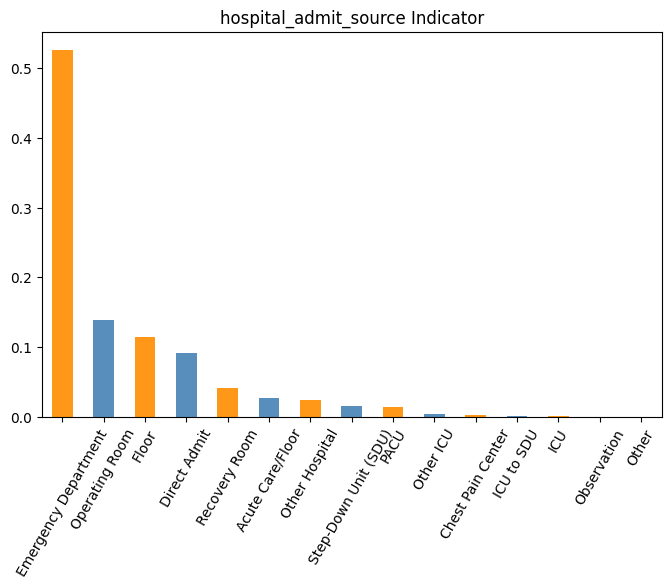

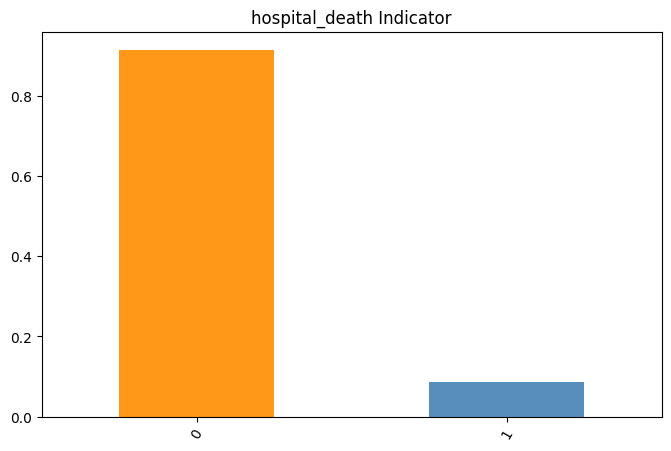

In [307]:
features_we_want_to_explore = ['gender', 'ethnicity', 'elective_surgery', 'apache_2_bodysystem', 'hospital_admit_source', target]
# explore feature
for feature in features_we_want_to_explore:
    fig = plt.figure(figsize = (8,5))
    train_df[feature].value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=60)
    plt.title(f'{feature} Indicator')
    plt.show()

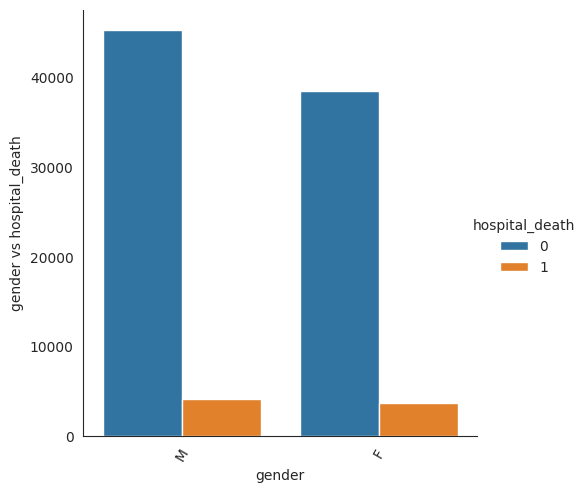

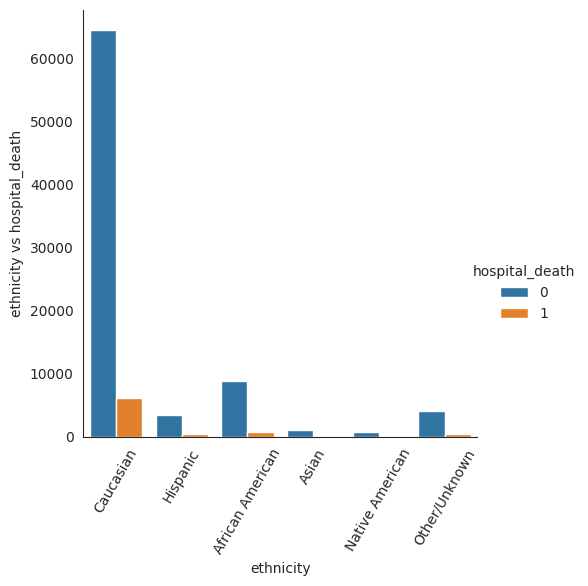

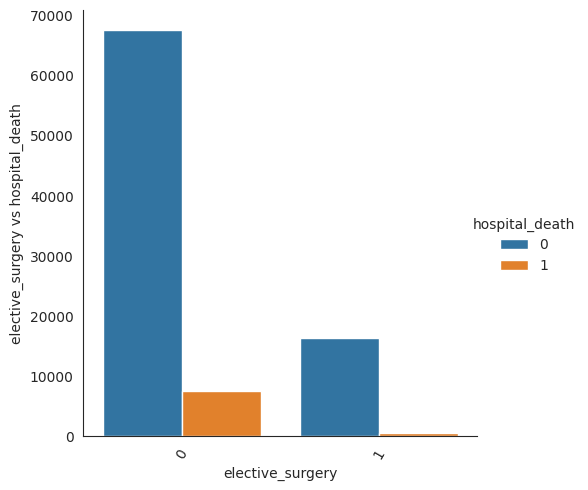

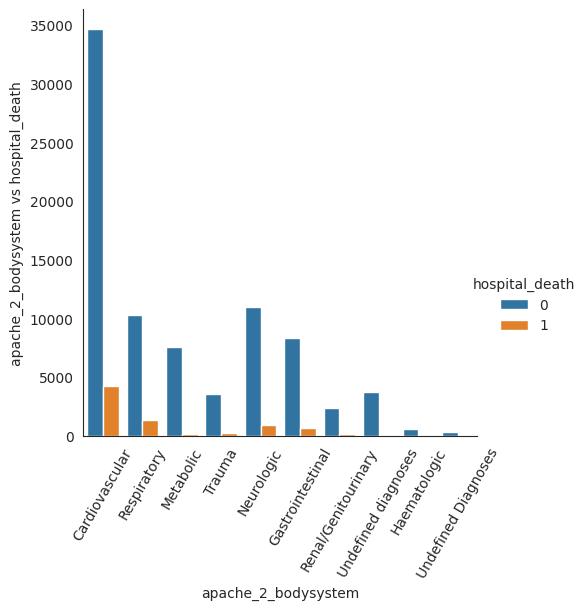

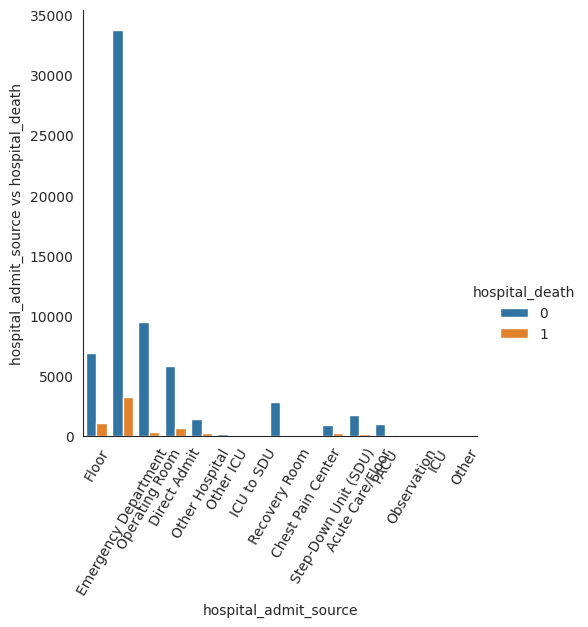

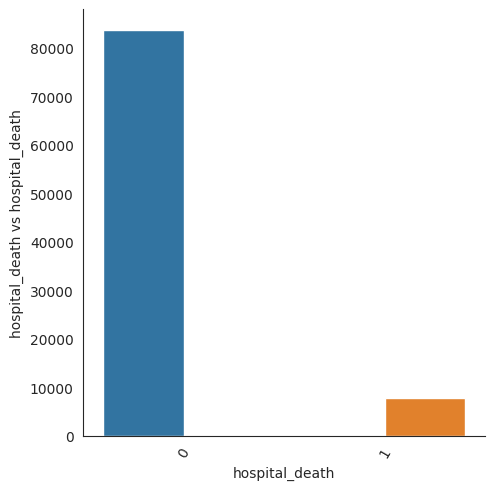

In [308]:
for feature in features_we_want_to_explore:
    with sns.axes_style('white'):
        g = sns.catplot(x=feature, data=train_df, kind='count', hue=target)
        g.set_xticklabels(rotation=60)
        g.set_ylabels(f'{feature} vs {target}')

Handle missing data

In [309]:
# check how many nulls are present
total_na = train_df.isna().sum().sum()
total_null = train_df.isnull().sum().sum()
total_na + total_null

11486984

In [310]:
# remove nulls - for continues values use mean, for discrete use mode

for column in list(train_df.columns):
    value_to_insert = None
    if train_df[column].dtype == float:
        #print(f'float value found! at: {column}')
        value_to_insert = train_df[column].mean()        
    else:
        value_to_insert = train_df[column].mode()[0]
    #print(f'column: {column}, replacing value: {value_to_insert}')
    train_df[column].fillna(value_to_insert, inplace=True)

total_na = train_df.isna().sum().sum()
total_null = train_df.isnull().sum().sum()
assert total_na == 0 and total_null == 0

Data label encoding

In [311]:
# get all columns where the values are strings
string_columns = train_df.select_dtypes(include=[object])
string_columns_names = list(string_columns.columns)

# replace these columns with their enumerated value
for column_name in string_columns_names:    
    enumerated_unique_values = list(enumerate(string_columns[column_name].unique()))
    value_to_index_mapper = dict([(y,x) for x,y in enumerated_unique_values])
    train_df[column_name].replace(value_to_index_mapper, inplace=True)

# make sure no string columns are left
assert len(train_df.select_dtypes(include=[object]).columns) == 0

Feature extraction

In [312]:
# columns in use
hospital_id_column_name = 'hospital_id'
patient_count_column_name = 'hospital_visit_count'
hospital_death_col_name = 'hospital_death'
hospital_death_count_col_name = 'hospital_death_count'
percent_of_deaths_col_name = 'percent_of_deaths_in_hospital'

In [313]:
# add feature counting how many visits were at a hospital

train_df[patient_count_column_name] = train_df.groupby(hospital_id_column_name)[hospital_id_column_name].transform('size')
train_df[[hospital_id_column_name, patient_count_column_name]]

,hospital_id,hospital_visit_count
0,118,4333
1,81,580
2,118,4333
3,118,4333
4,33,323
...,...,...
91708,30,515
91709,121,121
91710,195,215
91711,66,22


In [314]:
# count how many deaths were recorded for each hospital

train_df[hospital_death_count_col_name] = train_df.groupby(hospital_id_column_name)[hospital_death_col_name].transform('sum')
train_df[[hospital_id_column_name,hospital_death_count_col_name]]

,hospital_id,hospital_death_count
0,118,306
1,81,25
2,118,306
3,118,306
4,33,9
...,...,...
91708,30,24
91709,121,5
91710,195,12
91711,66,0


In [315]:
# get the percent of deaths among visits in a hospital

train_df[percent_of_deaths_col_name] = train_df.apply(lambda row: round(row[hospital_death_count_col_name] / row[patient_count_column_name], 4), axis=1)
train_df[[percent_of_deaths_col_name]]

,percent_of_deaths_in_hospital
0,0.0706
1,0.0431
2,0.0706
3,0.0706
4,0.0279
...,...
91708,0.0466
91709,0.0413
91710,0.0558
91711,0.0000


Get rid of columns that contains ID

In [316]:
train_df = train_df[train_df.columns.drop(list(train_df.filter(regex='_id')))]
train_df

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_visit_count,hospital_death_count,percent_of_deaths_in_hospital
0,0,68.000000,22.730000,0,0,0,180.3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,4333,306,0.0706
1,0,77.000000,27.420000,0,0,1,160.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1,1,580,25,0.0431
2,0,25.000000,31.950000,0,0,1,172.7,1,1,0,...,0.0,0.0,0.0,0.0,0.0,2,2,4333,306,0.0706
3,0,81.000000,22.640000,1,0,1,165.1,2,2,0,...,0.0,0.0,0.0,0.0,0.0,3,0,4333,306,0.0706
4,0,19.000000,29.185818,0,0,0,188.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,4,3,323,9,0.0279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.000000,23.060250,0,0,0,177.8,10,0,0,...,0.0,0.0,0.0,0.0,1.0,0,0,515,24,0.0466
91709,0,56.000000,47.179671,0,0,1,183.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,121,5,0.0413
91710,0,48.000000,27.236914,0,0,0,170.2,1,1,0,...,0.0,0.0,0.0,0.0,0.0,2,2,215,12,0.0558
91711,0,62.309516,23.297481,0,0,1,154.9,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1,1,22,0,0.0000


Quantile filtering anlysis

In [317]:
# lets see what happens if we remove the positive outliers by age
# (older people in the dataset)
quantile_by = 'age'
Q1 = train_df[quantile_by].quantile(0.25)
Q3 = train_df[quantile_by].quantile(0.75)
IQR = Q3 - Q1
threshold = 0.4 * IQR
print(f'max age in data: {train_df[quantile_by].max()}')
print(f'IQR: {IQR}')
print(f'threshold: {threshold}')

max age in data: 89.0
IQR: 22.0
threshold: 8.8


In [318]:
# removal of outliers from dataset
print(f'before dropping shape: {train_df.shape}')
dropped_rows = train_df[((train_df[quantile_by] > (Q3 + threshold)))]
left_rows = train_df[~((train_df[quantile_by] > (Q3 + threshold)))]
print(f'if we drop, the shape will be: {left_rows.shape}')
print(f'totally dropped {len(dropped_rows)} rows')
print(f'dropped ages {dropped_rows[quantile_by].unique()}')

before dropping shape: (91713, 185)
if we drop, the shape will be: (84242, 185)
totally dropped 7471 rows
dropped ages [87. 85. 88. 84. 86. 89.]


In [319]:
# what will be if we drop the age outliers ?
dropped_rows_dead = len(dropped_rows[dropped_rows[target] == 1])
dropped_rows_alive = len(dropped_rows[dropped_rows[target] == 0])
total_dead = len(train_df[train_df[target] == 1])
print(f'dropped patients which are dead: {len(dropped_rows[dropped_rows[target] == 1])}')
print(f'dropped patients which are alive: {len(dropped_rows[dropped_rows[target] == 0])}')
print(f'if we drop, we lose {round((dropped_rows_dead/total_dead) * 100,3)}% out of all records that are dead')

dropped patients which are dead: 1042
dropped patients which are alive: 6429
if we drop, we lose 13.165% out of all records
